In [11]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
np.random.seed(42)


# Постановка задачи

Для каждой арабской цифры имеется скан записи на бумаге (`./data/train/image`) и запись произношения на английском языке разными дикторами (`./data/train/voice`)

Требуется построить модель для классификации цифр

In [240]:
import os
import PIL
IMAGE_TRAIN_PATH = "./data/train/image"
VOICE_TRAIN_PATH = "./data/train/voice"
IMAGE_TEST_PATH = "./data/test/image/"
VOICE_TEST_PATH = "./data/test/voice/"

def read_image(path):
    return PIL.Image.open(path).convert('L')

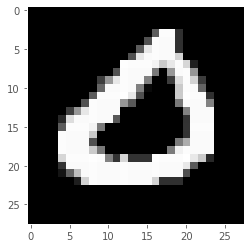

In [245]:
img = read_image(os.path.join(IMAGE_TRAIN_PATH, "0_3.png"))
plt.imshow(img, cmap='gray')
plt.grid(False);

In [246]:
import IPython.display as ipd

ipd.Audio(os.path.join(VOICE_TRAIN_PATH, "0_3.wav"))

### Представление изображения

In [247]:
img = read_image(os.path.join(IMAGE_TRAIN_PATH, "0_3.png"))

In [248]:
type(img)

PIL.Image.Image

In [249]:
np_img = np.array(img)
np_img.shape

(28, 28)

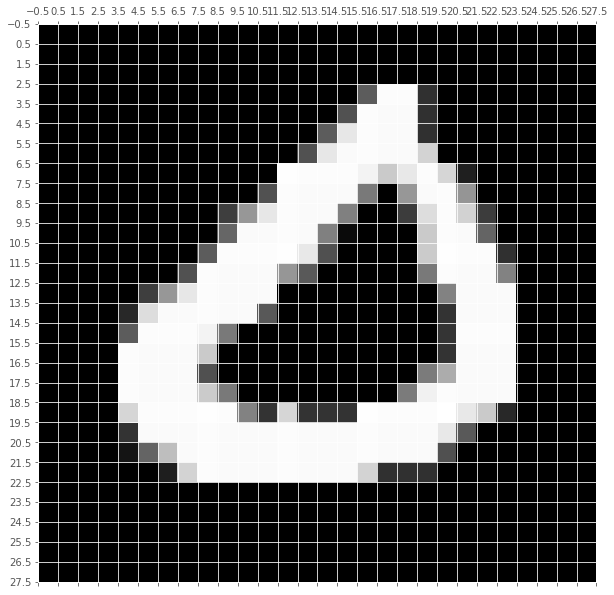

In [250]:
plt.figure(figsize=(10,10))
plt.matshow(np_img, fignum=1, cmap='gray')
plt.xticks(np.arange(-0.5, 28, 1))
plt.yticks(np.arange(-0.5, 28, 1))
plt.show()

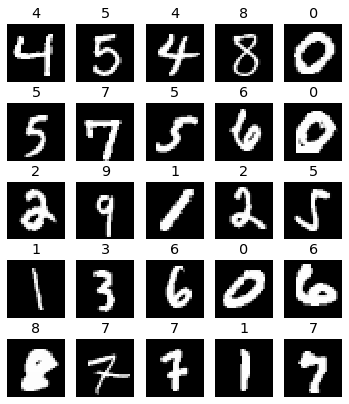

In [251]:
train_image_names = np.array(os.listdir(IMAGE_TRAIN_PATH))
order = np.random.permutation(len(train_image_names))
shuffled_train = train_image_names[order]

plt.figure(figsize=(6, 7))
for i in range(25):
    image_name = shuffled_train[i]
    target = image_name[:1]
    img = read_image(os.path.join(IMAGE_TRAIN_PATH, image_name))
    plt.subplot(5, 5, i+1)
    plt.imshow(img, cmap=plt.cm.Greys_r)
    plt.title(target)
    plt.axis('off')

### Работа с изображениями

На занятиях до этого объект описывался вектором (например, в задаче предсказания цен на недвижимость) или мы сводили представление объекта к векторному (работа с текстовыми данными). 

Представим изрображение в виде вектора

In [252]:
A = np.array([
    [1, 2, 3, 4],
    [5, 6, 7, 8],
    [9, 0, 1, 2]
])

A.reshape(-1)

array([1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2])

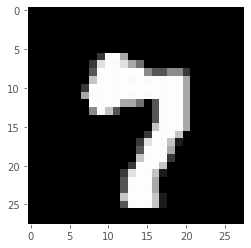

In [253]:
plt.imshow(img, cmap='gray')
plt.grid(False);

In [254]:
np_img = np.array(img)

In [255]:
np_img.shape

(28, 28)

In [256]:
vectorized_img = np_img.reshape(-1)

In [257]:
vectorized_img.shape

(784,)

### Сигнал

In [259]:
import librosa
import librosa.display

Можно было и [scipy](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.io.wavfile.read.html) использовать

In [260]:
def load_wav(path):
    return librosa.load(path, sr=8000)

In [261]:
signal, sr = load_wav(os.path.join(VOICE_TRAIN_PATH, '0_3.wav'))

In [262]:
print("duration: {} seconds".format(signal.size / sr))

duration: 0.67425 seconds


In [263]:
time_axis = 1000 * np.arange(len(signal)) / sr

In [264]:
hop_length = 256
n_fft = 256

spectrogram = abs(librosa.stft(
    signal, n_fft=n_fft, hop_length=hop_length
))

физический смысл:

`hop_length` - количество отсчетов, которые подвергаются преобразованию Фурье

`n_fft` - ответственен за спектральное разрешение

In [267]:
frequencies = [500, 1000, 5500, 6000]
SR = 22050
T = 2.0
t = np.linspace(0, T, int(sr * T))

for frequency in frequencies:
    music = np.sin(2 * np.pi * frequency * t)
    ipd.display(ipd.Audio(music, rate=SR))

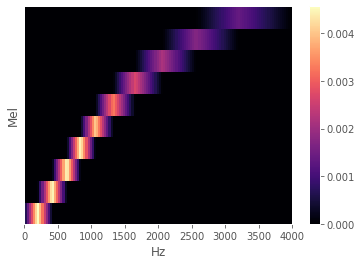

In [268]:
mel = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=10)

librosa.display.specshow(mel, sr=sr, hop_length=hop_length, 
                         x_axis='linear');
plt.ylabel('Mel')
plt.colorbar();

#### [Кепстр](https://ru.wikipedia.org/wiki/%D0%9A%D0%B5%D0%BF%D1%81%D1%82%D1%80)

Хотим извлечь спектральную огибающую

Что можно применить?

#### Извлечение MFCC

In [269]:
features_mfcc = librosa.feature.mfcc(
    signal, sr=sr, n_mfcc=13, hop_length=hop_length
)

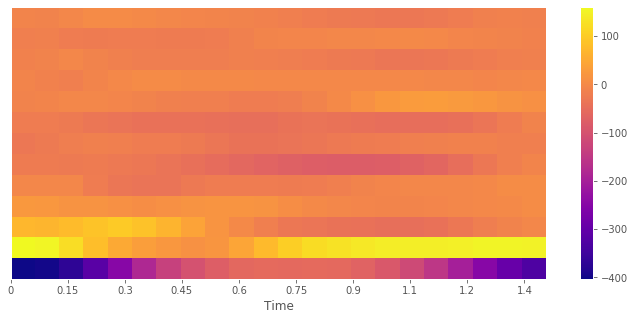

In [270]:
plt.figure(figsize=(12,5))
librosa.display.specshow(
    features_mfcc, sr=sr,
    x_axis="time", cmap="plasma")
plt.colorbar();

In [271]:
features_mfcc.shape

(13, 22)

In [272]:
another_signal, sr = load_wav(
    os.path.join(VOICE_TRAIN_PATH, '0_0.wav')
)

In [273]:
another_features_mfcc = librosa.feature.mfcc(
    another_signal, sr=sr, n_mfcc=13, hop_length=hop_length
)

In [274]:
features_mfcc.shape, another_features_mfcc.shape

((13, 22), (13, 16))

In [275]:
signal.size / sr, another_signal.size / sr

(0.67425, 0.494625)

# Извлечение признаков

In [276]:
import pandas as pd

In [277]:
def extract_image_features(image_folder):
    image_vectors = []
    indices = []
    for image_name in os.listdir(image_folder):
        index = os.path.splitext(image_name)[0]
        indices.append(index)
        image = read_image(os.path.join(image_folder, image_name))
        image_vector = np.array(image).reshape(-1)
        image_vectors.append(image_vector)
    return pd.DataFrame({
        'index': indices,
        'image_vector': image_vectors,
})

In [285]:
image_features = extract_image_features(IMAGE_TRAIN_PATH)
image_features1 = extract_image_features(IMAGE_TEST_PATH)


In [338]:
image_features1['index1']=image_features1['index'].astype(int)
image_features1=image_features1.sort_values('index1')

In [332]:
def extract_voice_features(voice_folder, numcep=13, hop_length=256):
    voice_vectors = []
    indices = []
    for record_name in os.listdir(voice_folder):
        index = os.path.splitext(record_name)[0]
        indices.append(index)
        signal, sr = load_wav(
            os.path.join(voice_folder, record_name))
        mfcc_features = librosa.feature.mfcc(
            signal, sr=sr, n_mfcc=numcep, hop_length=hop_length)
        voice_vector = mfcc_features.mean(axis=1)
        voice_vectors.append(voice_vector)
    return pd.DataFrame({
        'index': indices,
        'voice_vector': voice_vectors,
    })

In [333]:
voice_features = extract_voice_features(VOICE_TRAIN_PATH)
voice_features1 = extract_voice_features(VOICE_TEST_PATH)
voice_features1['index1']=voice_features1['index'].astype(int)
voice_features1=voice_features1.sort_values('index1')


In [335]:
voice_features1.head()

,index,voice_vector,index1
0,0,"[-314.85056, 92.66637, -20.075151, -14.916943,...",0
1,1,"[-379.849, 20.240627, 27.491215, -4.6642613, -...",1
112,2,"[-320.5155, 100.5417, -39.32484, -40.61958, -1...",2
223,3,"[-375.70108, 67.60232, 19.813986, 39.084743, -...",3
334,4,"[-181.09265, 62.741924, 1.4074062, 1.2044014, ...",4


In [339]:
dataset = image_features.merge(voice_features, on='index')
dataset1 = image_features1.merge(voice_features1, on='index1')


In [340]:
print(dataset.shape)
print(dataset1.shape)

(1500, 3)
(500, 5)


In [341]:
dataset["target"] = dataset["index"].apply(lambda x: int(x[0]))

In [342]:
dataset.head()

,index,image_vector,voice_vector,target
0,0_0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-206.83415, 57.273403, 17.93507, -16.07814, -...",0
1,0_1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-219.53279, 56.912598, 35.577553, -17.24239, ...",0
2,0_10,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-400.81183, 54.289345, 1.099009, 24.09175, -2...",0
3,0_100,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-152.03706, 95.13258, -27.010746, -14.315471,...",0
4,0_101,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-334.71457, 52.859722, -13.006522, 0.7758989,...",0


In [343]:
dataset1.head()

,index_x,image_vector,index1,index_y,voice_vector
0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,"[-314.85056, 92.66637, -20.075151, -14.916943,..."
1,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,1,"[-379.849, 20.240627, 27.491215, -4.6642613, -..."
2,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,2,"[-320.5155, 100.5417, -39.32484, -40.61958, -1..."
3,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,3,"[-375.70108, 67.60232, 19.813986, 39.084743, -..."
4,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,4,"[-181.09265, 62.741924, 1.4074062, 1.2044014, ..."


# Выбираем модель


In [344]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

In [367]:
#Learning with random forest model
dataset1['index'] = dataset1.index
train_data=dataset
test_data=dataset1
X_train=np.vstack(train_data['image_vector'])
X_test=np.vstack(test_data['image_vector'])
# Y_train=np.vstack(train_data['target'])
# Y_test=np.vstack(test_data['target'])

model=RandomForestClassifier(n_estimators=400).fit(X_train,Y_train)
#clf.score(X_test,Y_test)
predictions=model.predict(X_test)
dataset1['image1'] = model.predict(X_test)

C:\Users\rtut6\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


In [368]:
#Learning with XGB model
train_data=dataset
test_data=dataset1
X_train=np.vstack(train_data['image_vector'])
X_test=np.vstack(test_data['image_vector'])
Y_train=np.vstack(train_data['target'])
# Y_test=np.vstack(test_data['target'])

model = XGBClassifier(random_state=42, seed=3, colsample_bytree=0.6, subsample=0.6, n_estimators=1000)
model.fit(X_train,Y_train)
dataset1['image2'] = model.predict(X_test)


C:\Users\rtut6\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\rtut6\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [377]:
#Models ensembling
#If two "voice" models have different results for the same sample than we take image_XGB ("image2") result as the final
for i in range(0,499):
    if (dataset1['voice1'][i]-dataset1['voice2'][i])!=0:
        dataset1['sum'][i]=dataset1['image2'][i]
    else:
        dataset1['sum'][i]=dataset1['voice2'][i]
submission = pd.DataFrame({
        "index":dataset1['index'],
        "target": dataset1['voice2']
})
submission.to_csv("Kaggle2.csv", index=False)

**Что можно попробовать?**
* объединить картиночные и речевые признаки
* обучить модель на картинках и модель на MFCC, а затем построить ансамбль
* оптимизировать параметры классификатора с помощью кросс-валидации
* понизить размерность картиночных признаков
* исследовать зависимость качества предсказания от количества MFCC
* попробовать другие методы агрегации матрицы MFCC
* добавить дополнительные признаки (например, длительность аудиозаписи)